# Search Engine for Clinical Trial

In [1]:
!pip install wordcloud

In [2]:
import warnings
warnings.filterwarnings('ignore')

import re
import string
import pandas as pd
import numpy as np
from matplotlib import pyplot
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from pathlib import Path

import gensim
from gensim.models import Word2Vec
from gensim.models import FastText

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords # used for preprocessing
from nltk.stem import WordNetLemmatizer # used for preprocessing
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [3]:
#Mounting our google drive on google colab to access our data files
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#load the dataset
filepath = '/content/drive/MyDrive/clinical-trail-search-engine/Data/Covid19_clinical_trials.csv'
trial_data=pd.read_csv(filepath) #, index_col= 0

trial_data.head(5)

,Date added,Trial ID,Title,Brief title,Acronym,Abstract,Publication date,Active years,Phase,Conditions,...,Gender,Registry,Investigators/Contacts,Sponsors/Collaborators,GRID IDs,Country of Sponsor/Collaborator,Collaborating Funders,Funder Country,Source Linkout,Dimensions URL
0,2021-09-01,NCT05029245,"The 8-week, Prospective, Randomized Controlled...",IntraDermal Versus Intramuscular Comirnaty® Ef...,PRIDE,"The 8-week, Prospective, Randomized controlled...",2021-08-31,2021; 2022,Phase 3,Covid19 Vaccine; Covid19,...,All,ClinicalTrials.gov,NaN,Rajavithi Hospital,grid.415633.6,Thailand,NaN,NaN,https://clinicaltrials.gov/show/NCT05029245,https://app.dimensions.ai/details/clinical_tri...
1,2021-09-01,NCT05029037,High-dose Intravenous Vitamin C (HDIVC) as Adj...,High-dose Intravenous Vitamin C (HDIVC) as Adj...,HDIVC,The objective of this study is to evaluate the...,2021-09-15,2021; 2022,Phase 3,Covid19,...,All,ClinicalTrials.gov,NaN,NaN,NaN,NaN,NaN,NaN,https://clinicaltrials.gov/show/NCT05029037,https://app.dimensions.ai/details/clinical_tri...
2,2021-09-01,NCT05029011,Low-cost Sensor System for COVID-19 Patient Mo...,Low-cost Sensor System for COVID-19 Patient Mo...,NaN,"The MediByte VTS is a low-cost, portable devic...",2021-09-01,2021; 2022,NaN,The Focus is How Well the MediByte VTS Will Mo...,...,All,ClinicalTrials.gov,Helen Driver,Queen's University; National Research Council ...,grid.410356.5; grid.24433.32,Canada; Canada,National Research Council Canada,Canada,https://clinicaltrials.gov/show/NCT05029011,https://app.dimensions.ai/details/clinical_tri...
3,2021-09-01,NCT05028998,The Impact of COVID-19-related Medication Assi...,Covid-related Opioid Treatment Policy Evaluation,COPE,Our nation is facing the COVID-19 pandemic dur...,2021-09-01,2021; 2022; 2023,NaN,Opioid-use Disorder; Alcohol Use Disorder,...,All,ClinicalTrials.gov,NaN,Boston University; Patient-Centered Outcomes R...,grid.189504.1; grid.430109.f; grid.417499.6; g...,United States; United States; United States; U...,Patient-Centered Outcomes Research Institute; ...,United States; United States,https://clinicaltrials.gov/show/NCT05028998,https://app.dimensions.ai/details/clinical_tri...
4,2021-09-01,NCT05028881,Serological Responses to SARS-CoV-2 and Their ...,Hong Kong HIV SARS-CoV-2 Serology,NaN,Immunodeficiency associated with human immunod...,2020-05-16,2020; 2021; 2022; 2023,NaN,HIV Infections; SARS-CoV-2 Infection; Vaccinat...,...,All,ClinicalTrials.gov,Shui Shan Lee,Chinese University of Hong Kong,grid.10784.3a,China,NaN,NaN,https://clinicaltrials.gov/show/NCT05028881,https://app.dimensions.ai/details/clinical_tri...


In [5]:
display(trial_data.shape)
display(trial_data.info())

(12129, 21)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12129 entries, 0 to 12128
Data columns (total 21 columns):
 #   Column                           Non-Null Count  Dtype 
---  ------                           --------------  ----- 
 0   Date added                       12129 non-null  object
 1   Trial ID                         12129 non-null  object
 2   Title                            12129 non-null  object
 3   Brief title                      11696 non-null  object
 4   Acronym                          4051 non-null   object
 5   Abstract                         12127 non-null  object
 6   Publication date                 12129 non-null  object
 7   Active years                     11061 non-null  object
 8   Phase                            4719 non-null   object
 9   Conditions                       11911 non-null  object
 10  Intervention                     8947 non-null   object
 11  Gender                           12129 non-null  object
 12  Registry                        

None

In [6]:
str(trial_data['Abstract'][0])

'The 8-week, Prospective, Randomized controlled of IntraDermal administration of Comirnaty® 6 microgram compare to Intramuscular Comirnaty® 30 microgram by 28 days interval Efficacy Study in 4 groups of healthy volunteer ( 1 people who complete sinovac vaccination 2 people who received 1 dosage of AstraZeneca vaccine 3 naive vaccination 4 any other vaccination not in 1-3 with anti Spike antibody less than 650 AU/ ml) . Comparison of antibody level and T cell response to SAR-CoV-2 antigen in vitro after 28 day post vaccination is primary outcome and the side effect as well as infection rate in 8 weeks is secondary outcomes.\n\nDetailed Description\nThe 8-week, Prospective, Randomized controlled of IntraDermal administration of Comirnaty® 6 microgram compare to Intramuscular Comirnaty® 30 microgram by 28 days interval Efficacy Study in healthy volunteer.To compare the AntiSpike antibody, ( Anti RBD ) neutralized antibody ( if possible) of SAR-CoV-2 and T-cell response after injection wit

### Data Preprocessing

In [7]:
# Function to lemmatize Words
lemmatizer = WordNetLemmatizer()
def lemmatize(text):
    text = [lemmatizer.lemmatize(token) for token in text]
    return text

#function for data preprocessing of texts
def pre_processing(text):

  text = text.lower()
  text = ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",str(text)).split()) #remove urls
  text = re.sub(r'\d+', '', str(text)) #emove no.s
  text=text.replace('\n',' ')
  text = word_tokenize(text)
  text = [char for char in text if char not in string.punctuation]
  text = [word for word in text if word not in stopwords.words('english')]
  text = lemmatize(text)
  text = ' '.join(text)
  return text

In [8]:
#Applying preprocessing for Abstract and Title columns

trial_data['Abstract'] = trial_data['Abstract'].replace(np.nan, '')
trial_data['Title'] = trial_data['Title'].replace(np.nan, '')

for i in range(trial_data.shape[0]):
  trial_data['Abstract'][i]=pre_processing(str(trial_data['Abstract'][i]))
  trial_data['Title'][i]=pre_processing(str(trial_data['Title'][i]))

trial_data.head(5)

,Date added,Trial ID,Title,Brief title,Acronym,Abstract,Publication date,Active years,Phase,Conditions,...,Gender,Registry,Investigators/Contacts,Sponsors/Collaborators,GRID IDs,Country of Sponsor/Collaborator,Collaborating Funders,Funder Country,Source Linkout,Dimensions URL
0,2021-09-01,NCT05029245,week prospective randomized controlled intrade...,IntraDermal Versus Intramuscular Comirnaty® Ef...,PRIDE,week prospective randomized controlled intrade...,2021-08-31,2021; 2022,Phase 3,Covid19 Vaccine; Covid19,...,All,ClinicalTrials.gov,NaN,Rajavithi Hospital,grid.415633.6,Thailand,NaN,NaN,https://clinicaltrials.gov/show/NCT05029245,https://app.dimensions.ai/details/clinical_tri...
1,2021-09-01,NCT05029037,high dose intravenous vitamin c hdivc adjuvant...,High-dose Intravenous Vitamin C (HDIVC) as Adj...,HDIVC,objective study evaluate impact hdivc therapy ...,2021-09-15,2021; 2022,Phase 3,Covid19,...,All,ClinicalTrials.gov,NaN,NaN,NaN,NaN,NaN,NaN,https://clinicaltrials.gov/show/NCT05029037,https://app.dimensions.ai/details/clinical_tri...
2,2021-09-01,NCT05029011,low cost sensor system covid patient monitorin...,Low-cost Sensor System for COVID-19 Patient Mo...,NaN,medibyte vt low cost portable device developed...,2021-09-01,2021; 2022,NaN,The Focus is How Well the MediByte VTS Will Mo...,...,All,ClinicalTrials.gov,Helen Driver,Queen's University; National Research Council ...,grid.410356.5; grid.24433.32,Canada; Canada,National Research Council Canada,Canada,https://clinicaltrials.gov/show/NCT05029011,https://app.dimensions.ai/details/clinical_tri...
3,2021-09-01,NCT05028998,impact covid related medication assisted treat...,Covid-related Opioid Treatment Policy Evaluation,COPE,nation facing covid pandemic ongoing opioid ep...,2021-09-01,2021; 2022; 2023,NaN,Opioid-use Disorder; Alcohol Use Disorder,...,All,ClinicalTrials.gov,NaN,Boston University; Patient-Centered Outcomes R...,grid.189504.1; grid.430109.f; grid.417499.6; g...,United States; United States; United States; U...,Patient-Centered Outcomes Research Institute; ...,United States; United States,https://clinicaltrials.gov/show/NCT05028998,https://app.dimensions.ai/details/clinical_tri...
4,2021-09-01,NCT05028881,serological response sars cov temporal pattern...,Hong Kong HIV SARS-CoV-2 Serology,NaN,immunodeficiency associated human immunodefici...,2020-05-16,2020; 2021; 2022; 2023,NaN,HIV Infections; SARS-CoV-2 Infection; Vaccinat...,...,All,ClinicalTrials.gov,Shui Shan Lee,Chinese University of Hong Kong,grid.10784.3a,China,NaN,NaN,https://clinicaltrials.gov/show/NCT05028881,https://app.dimensions.ai/details/clinical_tri...


In [9]:
#Tokenize
tokens = [word_tokenize(word) for word in trial_data.Abstract ]

### EDA

In [21]:
#Find most common(top) words
from collections import Counter
count = Counter()
for text in trial_data.Abstract:
  for word in text.split():
    count[word] += 1

count.most_common(10)  #10 most common words

[('patient', 43187),
 ('covid', 43063),
 ('study', 37002),
 ('group', 15111),
 ('treatment', 14052),
 ('day', 14029),
 ('sars', 12882),
 ('cov', 12855),
 ('disease', 12853),
 ('clinical', 12847)]

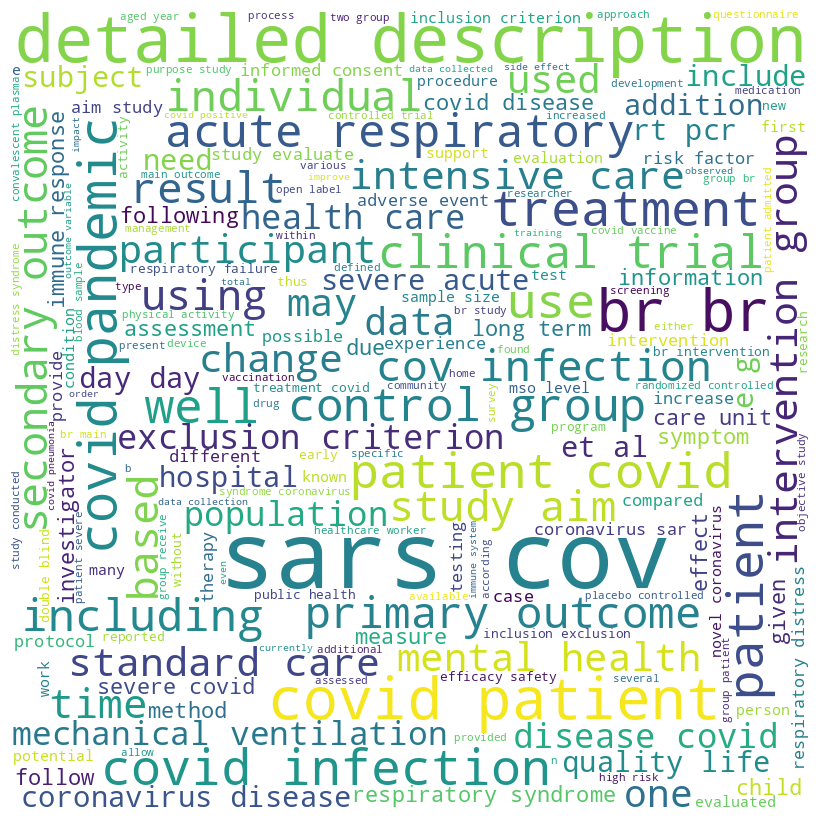

In [11]:
#creating word cloud from our tokens generated post preprocessing of Abstract column
from wordcloud import WordCloud
from textwrap import wrap
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
#comment_words = ' '
stopwords = set(STOPWORDS)
from pandas.core.common import flatten

# iterate through the csv file


word_cloud=flatten(tokens)
word_cloud=' '.join(word_cloud)


wordcloud = WordCloud(width = 800, height = 800,
            background_color ='white',
            stopwords = stopwords,
            min_font_size = 10).generate(word_cloud)

# plot the WordCloud image
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()

### Word2Vec Skipgram model

##### At a high level Word2Vec is a unsupervised learning algorithm that uses a shallow neural network (with one hidden layer) to learn the vectorial representations of all the unique words/phrases for a given corpus.

The advantage that word2vec offers is it tries to preserve the semantic meaning behind those terms. For example, a document may employ the words "dog" and "canine" to mean the same thing, but never use them together in a sentence. Ideally, the word2vec algorithm would be able to learn the context and place them together in similar vector semantic space.
Skip-gram variant takes a target word and tries to predict the surrounding context words
>**window size**

Word2Vec has 'window' hyperparameter to the algorithm that quantifies the word "nearby". A typical window size might be 5, meaning 5 words behind and 5 words ahead (10 in total).
> **min_count**

min_count is for pruning the internal dictionary. Words that appear only once or twice in a billion-word corpus are probably uninteresting typos and garbage. In addition, there’s not enough data to make any meaningful training on those words, so it’s best to ignore them:
default value of min_count=5
>**vector_size**

vector_size is the number of dimensions (N) of the N-dimensional space that gensim Word2Vec maps the words onto.
Bigger size values require more training data, but can lead to better (more accurate) models. Reasonable values are in the tens to hundreds.
>**workers**

workers , the last of the major parameters is for training parallelization, to speed up training. The workers parameter only has an effect if you have Cython installed. Without Cython, you’ll only be able to use one core because of the GIL (and word2vec training will be miserably slow).
>**Memory**

At its core, word2vec model parameters are stored as matrices (NumPy arrays). Each array is #vocabulary (controlled by the min_count parameter) times vector size (the vector_size parameter) of floats (single precision aka 4 bytes).
Three such matrices are held in RAM (work is underway to reduce that number to two, or even one). So if your input contains 100,000 unique words, and you asked for layer vector_size=200, the model will require approx. 100,000*200*4*3 bytes = ~229MB.

There’s a little extra memory needed for storing the vocabulary tree (100,000 words would take a few megabytes), but unless your words are extremely loooong strings, memory footprint will be dominated by the three matrices above.

>**sg** ({0, 1}, optional) – Training algorithm: 1 for skip-gram; otherwise CBOW.

>**hs** ({0, 1}, optional) – If 1, hierarchical softmax will be used for model training. If 0, and negative is non-zero, negative sampling will be used.

>**negative** (int, optional) – If > 0, negative sampling will be used, the int for negative specifies how many “noise words” should be drawn (usually between 5-20). If set to 0, no negative sampling is used.
>**alpha** (float, optional) – The initial learning rate.

>**min_alpha** (float, optional) – Learning rate will linearly drop to min_alpha as training progresses.

In [12]:
#training skipgram model for window = 3
skipgram = Word2Vec(tokens, vector_size =50, window = 3, min_count=2,sg = 1)
print(skipgram)
skipgram.save('skipgramx1.bin')

Word2Vec<vocab=27307, vector_size=50, alpha=0.025>


In [13]:
#training skipgram model for window = 1
skipgram = Word2Vec(tokens, vector_size =100, window = 1, min_count=2,sg = 1)
print(skipgram)
skipgram.save('skipgramx11.bin')

Word2Vec<vocab=27307, vector_size=100, alpha=0.025>


In [14]:
#training fasttext Model, with skipgram
FastText=FastText(tokens,vector_size=100, window=2, min_count=2, workers=5, min_n=1, max_n=2,sg=1)
FastText.save('FastText.bin')


In [17]:
# Loading the model skipgram and fasttext model
skipgram1 = Word2Vec.load('skipgramx1.bin')
skipgram = Word2Vec.load('skipgramx11.bin')
FastText = Word2Vec.load('FastText.bin')

In [18]:
# Similar words - skipgram
skipgram.wv.most_similar(positive=['covid'],topn=10)


[('sars', 0.794407844543457),
 ('covd', 0.7800454497337341),
 ('ncp', 0.7720544934272766),
 ('virologically', 0.748722493648529),
 ('cov', 0.747269868850708),
 ('sarscov', 0.7445510029792786),
 ('sari', 0.7445449233055115),
 ('acutely', 0.7384055256843567),
 ('pasc', 0.7377539277076721),
 ('corona', 0.7343671321868896)]

In [19]:
skipgram1.wv.most_similar(positive=['covid'],topn=10)

[('ncip', 0.8329047560691833),
 ('cov', 0.8203659653663635),
 ('covd', 0.819375216960907),
 ('microbiologically', 0.8155977725982666),
 ('ncp', 0.8119529485702515),
 ('sars', 0.8074769377708435),
 ('acutely', 0.8066567182540894),
 ('infection', 0.8058467507362366),
 ('presumed', 0.7988818287849426),
 ('kazakhstan', 0.7987191677093506)]

In [22]:
skipgram.wv.most_similar(positive=['day'],topn=10)

[('hour', 0.812663733959198),
 ('upto', 0.7801303267478943),
 ('fourteen', 0.7621079087257385),
 ('hourly', 0.7578499913215637),
 ('eos', 0.7514236569404602),
 ('vfd', 0.7507635354995728),
 ('eot', 0.7479917407035828),
 ('week', 0.7470111846923828),
 ('till', 0.7212167382240295),
 ('spaced', 0.7134716510772705)]

In [23]:
skipgram1.wv.most_similar(positive=['day'],topn=10)

[('fourteen', 0.8651873469352722),
 ('hour', 0.8523948192596436),
 ('upto', 0.8450971841812134),
 ('hourly', 0.8445858359336853),
 ('week', 0.8365347981452942),
 ('eot', 0.8291324973106384),
 ('vfd', 0.8182936310768127),
 ('washout', 0.8138945698738098),
 ('eos', 0.8059095144271851),
 ('whichever', 0.8022367358207703)]

In [24]:
# Similar words - fasttext

FastText.wv.most_similar(positive=['lung'],topn=10)

[('lungiq', 0.7289964556694031),
 ('pulmonary', 0.7043033242225647),
 ('leung', 0.7001180052757263),
 ('silicovilung', 0.6727821826934814),
 ('volunteering', 0.6661289930343628),
 ('sung', 0.6644347310066223),
 ('leading', 0.6613746285438538),
 ('laying', 0.6587396860122681),
 ('cholangiopancreatography', 0.6546406745910645),
 ('voluntary', 0.6534160375595093)]

In [25]:
FastText.wv.most_similar(positive=['breathing'],topn=10)

[('breaching', 0.9149886965751648),
 ('rebreathing', 0.9144529700279236),
 ('breathes', 0.897203803062439),
 ('breathe', 0.8971067667007446),
 ('breathed', 0.8787594437599182),
 ('nosebreathing', 0.8643914461135864),
 ('bathing', 0.8601434230804443),
 ('breath', 0.8545409440994263),
 ('breaking', 0.8529123663902283),
 ('thickening', 0.8493319749832153)]

### Plotting th word embeddings

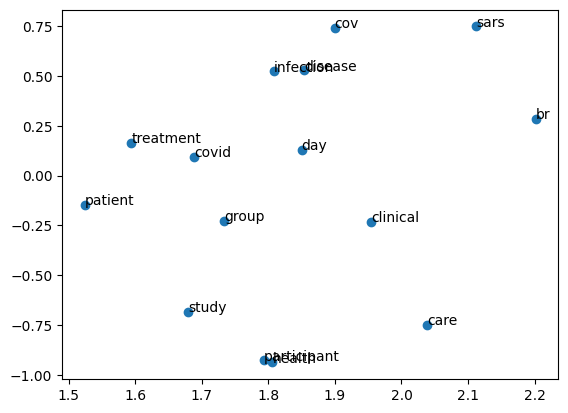

None

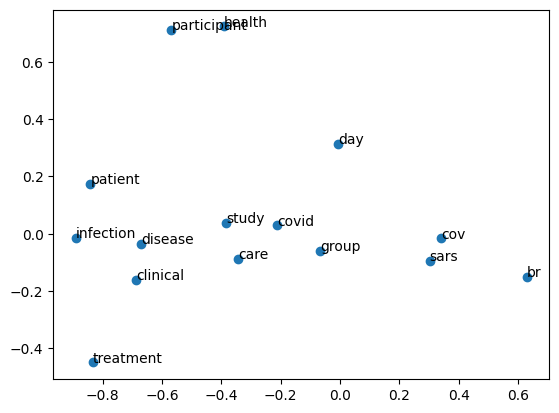

None

In [58]:
#Function to plot word embeddings with skipgram & FastText
def plot_func(algo):
  X = algo.wv[algo.wv.index_to_key]

  #applying PCA to convert data into two dimensions
  pca = PCA(n_components=2)
  result = pca.fit_transform(X)
  #convert the word embedding array into dataframe with 2 dimensions
  word_embedding = pd.DataFrame(result,columns=['d0', 'd1'])
  word_embedding.index = skipgram.wv.index_to_key
  #plot 2-D representation of each word
  pyplot.scatter(word_embedding.iloc[:15,0],word_embedding.iloc[:15,1])
  for i, word in enumerate(word_embedding.index[:15]):
    pyplot.annotate(word, xy=(word_embedding.iloc[i,0],word_embedding.iloc[i,1]))
  pyplot.show()


display(plot_func(skipgram))
display(plot_func(FastText))

>with Skipgram

In [34]:
#stroing arrays of all words
X = skipgram.wv[skipgram.wv.index_to_key]

#applying PCA to convert data into two dimensions
pca = PCA(n_components=2)                    #applying PCA to convert data into two dimensions
result = pca.fit_transform(X)
result

array([[ 1.5242227 , -0.14761207],
       [ 1.6888293 ,  0.09467325],
       [ 1.679688  , -0.6816243 ],
       ...,
       [-0.52913946, -0.03540002],
       [-0.4611125 , -0.03592195],
       [-0.5419422 , -0.02677112]], dtype=float32)

In [55]:
#convert the word embedding array into dataframe with 2 dimensions
word_embedding = pd.DataFrame(result,columns=['d0', 'd1'])
word_embedding.index = skipgram.wv.index_to_key

word_embedding.head(15)

,d0,d1
patient,1.524223,-0.147612
covid,1.688829,0.094673
study,1.679688,-0.681624
group,1.734182,-0.226487
treatment,1.594408,0.164805
day,1.850057,0.128743
sars,2.111853,0.748053
cov,1.899506,0.739710
disease,1.854064,0.527438
clinical,1.954879,-0.232145


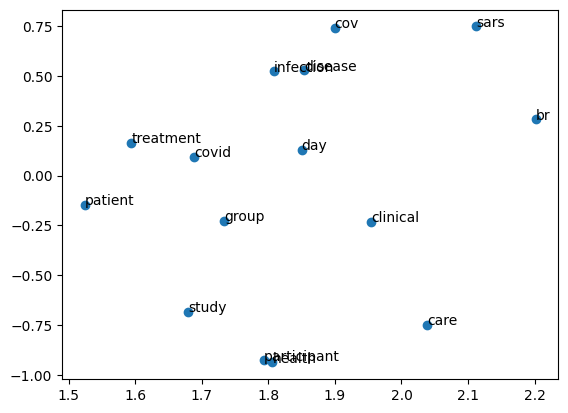

In [57]:
#words embeddings on the plot to check 2-D representation of each word
pyplot.scatter(word_embedding.iloc[:15,0],word_embedding.iloc[:15,1])
for i, word in enumerate(word_embedding.index[:15]):
  pyplot.annotate(word, xy=(word_embedding.iloc[i,0],word_embedding.iloc[i,1]))
pyplot.show()

>with FastText

In [ ]:
#stroing arrays of all words
X = FastText.wv[FastText.wv.index_to_key]

#applying PCA to convert data into two dimensions
pca = PCA(n_components=2)                    #applying PCA to convert data into two dimensions
result = pca.fit_transform(X)
result

###References
1. https://towardsdatascience.com/introduction-to-word2vec-skip-gram-cb3e9533bcf1